In [152]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [183]:
import argparse
import pandas as pd 
import numpy as np
import time as t
import re
from nltk.stem import PorterStemmer
from sklearn.utils import resample, shuffle
pd.set_option('mode.chained_assignment', None)

import scipy.sparse as sp
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

import spacy
nlp = spacy.load("en_core_web_sm")

ps = PorterStemmer()

# **Data Loading**

In [184]:
train_df = pd.read_csv('/content/gdrive/MyDrive/Data/train.tsv',sep = "\t", header =0)
val_df = pd.read_csv('/content/gdrive/MyDrive/Data/dev.tsv',sep = "\t", header = 0)
test_df = pd.read_csv('/content/gdrive/MyDrive/Data/test.tsv',sep = "\t", header = 0)

In [185]:
print("Dataset size:", len(train_df))

Dataset size: 12239


In [186]:
print("Dataset size:", len(val_df))

Dataset size: 999


In [187]:
print("Dataset size:", len(test_df))

Dataset size: 859


In [188]:
train_df.columns =['tweet', 'task']
val_df.columns = ['tweet', 'task']
test_df.columns = ['tweet', 'task']

In [190]:
train_df.head()

,tweet,task
0,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF
1,Amazon is investigating Chinese employees who ...,NOT
2,"@USER Someone should'veTaken"" this piece of sh...",OFF
3,@USER @USER Obama wanted liberals &amp; illega...,NOT
4,@USER Liberals are all Kookoo !!!,OFF


In [189]:
val_df.head()

,tweet,task
0,@USER He is not a troll he is simply dumb but ...,OFF
1,@USER I understand Annie she is stuck in betwe...,NOT
2,@USER @USER Hillary was blaming women not too ...,OFF
3,@USER @USER I support Jahs blessings on his hu...,OFF
4,@USER You are runnning on the word of somethin...,NOT


In [161]:
test_df.head()

,tweet,task
0,"#ConstitutionDay is revered by Conservatives, ...",NOT
1,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT
2,#Watching #Boomer getting the news that she is...,NOT
3,#NoPasaran: Unity demo to oppose the far-right...,OFF
4,. . . What the fuck did he do this time?,OFF


# **DATA PREPROCESS**

NOT    8192
OFF    4047
Name: task, dtype: int64


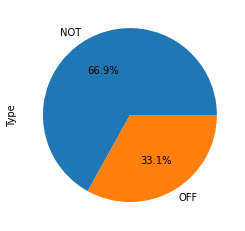

In [191]:
#before up-down sampling the label distribution

print(train_df["task"].value_counts())

train_df.groupby('task').size().plot(kind='pie',
                                       y = "v1",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [192]:
def up_down_sampling(train_df):
  off =  resample(train_df[train_df['task']=='OFF'], replace=False, n_samples=4000)
  Not = resample(train_df[train_df['task']=='NOT'], replace=False, n_samples=4000)
  df_train = pd.concat([off, Not])
  train_df = shuffle(df_train)
  return train_df

In [193]:
def apply_stem(tweet):
	words = [ps.stem(w) for w in tweet.split()]
	return ' '.join(words)

def remove_newline(tweet):
	_tweet = re.sub('\n', '', tweet)
	return _tweet

	
def apply_lemma(tweet):
	doc = nlp(tweet)
	lemma = [token.lemma_ for token in doc]
	return ' '.join(lemma)
 
def remove_stopwords(tweet):
	doc = nlp(tweet)
	stop = [token.text for token in doc if not token.is_stop and not token.is_punct]
	return ' '.join(stop)
 	

def clean_data(tweet):
    splitted_tweet = tweet.lower().split()
    clean_tweet = []
    previous_word = None
    user_count = 0
    for word in splitted_tweet:
        #if word not in spacy_stopwords:
        word = re.sub("[#@]","",word)
        word = re.sub("!"," !",word)
        word = re.sub("[?]"," ?",word)
        
        if(word == "user"):
          user_count += 1
          
        if(word == "user" and previous_word == "user"):
          pass
        else:
          clean_tweet.append(word)
          
        previous_word = word
          
    return " ".join(clean_tweet), user_count

# Calculating number of Global Positioning Entity in a text
def count_gpe(txt):
	return sum([1 for token in nlp(txt).ents if token.label_ == 'GPE'])


# Claculating Number of Organisation in a Text
def count_org(txt):
	return sum([1 for token in nlp(txt).ents if token.label_ == 'ORG'])


# Calculating Number of Sentence in a text
def count_sentence(txt):
	doc = nlp(txt)
	return len([sent.text for sent in doc.sents])


#Extract only Noun and Proper Noun
def extract_noun(tweet):
	doc = nlp(tweet)
	cleaned_doc = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and (token.pos_ == 'NOUN' or token.pos_ == 'PROPN')]
	return ' '.join(cleaned_doc)


# Adding Pos Tag with the corresponding words
def spacy_pos(tweet):
	doc = nlp(tweet)
	cleaned = [token.lemma_ + '_' + token.pos_ for token in doc if not token.is_stop and not token.is_punct]
	return ' '.join(cleaned)


#Normalize the Custom Features
def normalize(df):
	df['sentence_count'] /= df['sentence_count'].max()
	df['gpe_count'] /= df['gpe_count'].max()
	df['org_count'] /= df['org_count'].max()
	
	return df


In [194]:
if __name__ == "__main__":

  train_df = up_down_sampling(train_df)
  train_df = train_df.merge(train_df.tweet.apply(lambda x:pd.Series({'preprocessed':clean_data(x)[0], 'user_count': clean_data(x)[1], })), left_index=True, right_index=True)
  train_df.drop('user_count', inplace=True, axis=1)
  val_df = val_df.merge(val_df.tweet.apply(lambda x:pd.Series({'preprocessed':clean_data(x)[0], 'user_count': clean_data(x)[1]})), left_index=True, right_index=True)
  val_df.drop('user_count', inplace=True, axis=1)

  test_df = test_df.merge(test_df.tweet.apply(lambda x:pd.Series({'preprocessed':clean_data(x)[0], 'user_count': clean_data(x)[1]})), left_index=True, right_index=True)
  test_df.drop('user_count', inplace=True, axis=1)
	
  start = t.time()
  train_df['gpe_count'] = [sum([1 for token in nlp(txt).ents if token.label_ == 'GPE']) for txt in train_df['tweet']]
  val_df['gpe_count'] = [sum([1 for token in nlp(txt).ents if token.label_ == 'GPE']) for txt in val_df['tweet']]
  test_df['gpe_count'] = [sum([1 for token in nlp(txt).ents if token.label_ == 'GPE'])
  for txt in test_df['tweet']]
  stop = t.time()
  print("\n Count GPE Time: {}".format(stop - start))
  start = t.time()
  train_df['org_count'] = [sum([1 for token in nlp(txt).ents if token.label_ == 'ORG']) for txt in train_df['tweet']]
  val_df['org_count'] = [sum([1 for token in nlp(txt).ents if token.label_ == 'ORG']) for txt in val_df['tweet']]
  test_df['org_count'] = [sum([1 for token in nlp(txt).ents if token.label_ == 'ORG']) for txt in test_df['tweet']]
  
  stop = t.time()
  print("\n Count Name_entity Time: {}".format(stop - start))
  
  start = t.time()
  
  train_df['sentence_count'] = [len([sent.text for sent in nlp(tweet).sents])for tweet in train_df['tweet']]
  
  val_df['sentence_count'] = [len([sent.text for sent in nlp(tweet).sents])for tweet in val_df['tweet']]
  
  test_df['sentence_count'] = [len([sent.text for sent in nlp(tweet).sents]) for tweet in test_df['tweet']]
  
  stop = t.time()
  print("\n Count Sentence: {}".format(stop - start))
  
  start = t.time()
  train_df['pos_tagged'] = [' '.join([token.lemma_ + '_' + token.pos_ for token in nlp(tweet) if not token.is_stop and not token.is_punct])for tweet in train_df['preprocessed']]
  
  val_df['pos_tagged'] = [' '.join([token.lemma_ + '_' + token.pos_ for token in nlp(tweet) if not token.is_stop and not token.is_punct])for tweet in val_df['preprocessed']]
  
  test_df['pos_tagged'] = [' '.join([token.lemma_ + '_' + token.pos_ for token in nlp(tweet) if not token.is_stop and not token.is_punct])for tweet in test_df['preprocessed']]
  
  stop = t.time()
  print("\n Adding Pos Tag: {}".format(stop - start))
  start = t.time()
  
  train_df['noun'] = [' '.join([token.lemma_ for token in nlp(tweet) if not token.is_stop and not token.is_punct and (token.pos_ == 'NOUN' or token.pos_ == 'PROPN')])for tweet in train_df['preprocessed']]
  val_df['noun'] = [' '.join([token.lemma_ for token in nlp(tweet) if not token.is_stop and not token.is_punct and (token.pos_ == 'NOUN' or token.pos_ == 'PROPN')])for tweet in val_df['preprocessed']]
  test_df['noun'] = [' '.join([token.lemma_ for token in nlp(tweet) if not token.is_stop and not token.is_punct and (token.pos_ == 'NOUN' or token.pos_ == 'PROPN')])for tweet in test_df['preprocessed']]
  
  stop = t.time()
  print("\n Noun and Proper Noun Extraction: {}".format(stop - start))
  
  train_df = normalize(train_df)
  val_df = normalize(val_df)
  test_df = normalize(test_df)
  
  train_df.to_csv('/content/gdrive/MyDrive/Data/preprocessed data/processed_train.csv', index=False)
  val_df.to_csv('/content/gdrive/MyDrive/Data/preprocessed data/processed_val.csv', index=False)
  test_df.to_csv('/content/gdrive/MyDrive/Data/preprocessed data/processed_test.csv', index=False)



 Count GPE Time: 83.06677317619324

 Count Name_entity Time: 79.88586759567261

 Count Sentence: 83.17310166358948

 Adding Pos Tag: 78.96578979492188

 Noun and Proper Noun Extraction: 78.07957291603088


In [195]:
train_df = pd.read_csv('/content/gdrive/MyDrive/Data/preprocessed data/processed_train.csv')
val_df = pd.read_csv('/content/gdrive/MyDrive/Data/preprocessed data/processed_val.csv')
test_df = pd.read_csv('/content/gdrive/MyDrive/Data/preprocessed data/processed_val.csv')

OFF    4000
NOT    4000
Name: task, dtype: int64


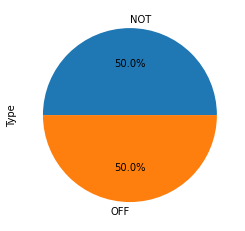

In [196]:
#after up-down sampling
print(train_df["task"].value_counts())

train_df.groupby('task').size().plot(kind='pie',
                                       y = "v1",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [197]:
train_df.head()

,tweet,task,preprocessed,gpe_count,org_count,sentence_count,pos_tagged,noun
0,@USER Who will abuse it the most: liberals or ...,OFF,user who will abuse it the most: liberals or r...,0.0,0.117647,0.0625,user_NOUN abuse_VERB liberal_NOUN rino_NOUN,user liberal rino
1,@USER @USER But we can do better. As evidenced...,NOT,user but we can do better. as evidenced by the...,0.0,0.117647,0.1875,user_NOUN well_ADV evidence_VERB gifford_NOUN ...,user gifford law center study gun control gun ...
2,@USER @USER @USER @USER @USER @USER @USER @USE...,NOT,"user this is the vetsresistsquadron"" is bullsh...",0.0,0.000000,0.1875,user_NOUN vetsresistsquadron_NOUN bullshit_ADJ...,user vetsresistsquadron girl scout veteran vet...
3,@USER Great stalk..hunters like yourself and y...,OFF,user great stalk..hunters like yourself and yo...,0.0,0.058824,0.0625,user_PROPN great_PROPN stalk_NOUN hunter_NOUN ...,user great stalk hunter wife reason animal lib...
4,@USER HE IS IM SO PROUD OF HIM,NOT,user he is im so proud of him,0.0,0.000000,0.1250,user_NOUN m_VERB proud_ADJ,user


# **Classic Model**

In [198]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import spacy

nlp = spacy.load("en_core_web_sm")
import argparse
import scipy.sparse as sp
import pickle
import warnings
warnings.filterwarnings("ignore")

In [199]:
def identity(x):
    """Dummy function that just returns the input"""
    return x


def write_to_file(labels, output_file):
    '''Write list to file'''
    with open(output_file, "w") as out_f:
        for line in labels:
            out_f.write(line.strip() + '\n')
    out_f.close()


def tokenizer(tweet):
    doc = nlp(tweet)
    tokens = [word.text for word in doc]
    return tokens


def get_score(classifier, X_test, Y_test, output_file):
    # Given a trained model, predict the label of a new set of data.
    Y_pred = classifier.predict(X_test)
    # Calculates the accuracy score of the trained model by comparing predicted labels with actual labels.
    acc = accuracy_score(Y_test, Y_pred)
    output_file = True
    if output_file:
        write_to_file(Y_pred, output_file)
    print(classification_report(Y_test, Y_pred))

    return acc


def base_model(vec, X_train, Y_train):
    print("Navie Bayes Classification")
    model = MultinomialNB()

    classifier = Pipeline([('vec', vec), ('cls', model)])
    classifier.fit(X_train, Y_train)

    return classifier


def optimize_rf(vec, X_train, Y_train, seed):
    print("Random Forest Classification")
    model = RandomForestClassifier(criterion='gini', n_estimators=233, max_depth=10, max_features=0.064,
                                   random_state=seed)

    classifier = Pipeline([('vec', vec), ('cls', model)])
    classifier.fit(X_train, Y_train)

    return classifier


def optimize_knn(vec, X_train, Y_train):
    print("KNN Classification")
    model = KNeighborsClassifier(n_neighbors=118, weights='uniform', n_jobs=-1)

    classifier = Pipeline([('vec', vec), ('cls', model)])
    classifier.fit(X_train, Y_train)

    return classifier


def optimize_dt(vec, X_train, Y_train):
    print("Decision Tree Classification")
    model = DecisionTreeClassifier(
        splitter='best',
        max_depth=14,
        max_features=0.81,
        criterion='entropy',
        random_state=0
    )

    classifier = Pipeline([('vec', vec), ('cls', model)])
    classifier.fit(X_train, Y_train)

    return classifier


def optimize_svm(vec, X_train, Y_train, seed):
    print("SVM classification")
    if vec is None:
        svm_ = svm.SVC(kernel='linear', C=1.14, random_state=seed)
    else:
        svm_ = Pipeline([('vec', vec), ('cls', svm.SVC(kernel='linear', C=1.14, random_state=seed))])

    svm_.fit(X_train, Y_train)

    return svm_


def custom_feature(row):
    dic = {}
    dic['org_count'] = row['org_count']
    dic['sentence_count'] = row['sentence_count']
    dic['gpe_count'] = row['gpe_count']
    return dic


def ensemble(vec, X_train, Y_train, seed):
    print("Ensemble of Naive Bayes, Random Forest and SVM")

    nb = Pipeline([('vec_cn', vec), ('cls', MultinomialNB())])
    rf = Pipeline([('vec_tf', vec), ('cls', RandomForestClassifier(criterion='gini', n_estimators=233, max_depth=10,
                                                                   max_features=0.064, n_jobs=-1, random_state=seed))])
    svm_ = Pipeline([('vec_tf', vec), ('cls', svm.SVC(kernel='linear', C=1.14, random_state=seed))])

    estimators = [('nb', nb), ('rf', rf), ('svm', svm_)]

    ensemble_classifier = VotingClassifier(estimators, voting='hard')
    classifier = ensemble_classifier.fit(X_train, Y_train)

    return classifier

In [202]:
if __name__ == "__main__":

    """ Below code refactored for the format python LFD_assignment2.py -i <trainset> -ts <testset>.
        Normally, it is used with split_data function to experiment with different classifiers. """

    train = pd.read_csv('/content/gdrive/MyDrive/Data/preprocessed data/processed_train.csv')
    val= pd.read_csv('/content/gdrive/MyDrive/Data/preprocessed data/processed_val.csv')
    X_train, Y_train = train['preprocessed'], train['task']

    X_dev, Y_dev = val['preprocessed'], val['task']

    tfidf = False
    if tfidf:
        vec = TfidfVectorizer(preprocessor=identity, tokenizer=tokenizer)
    else:
        # Bag of Words vectorizer
        vec = CountVectorizer(preprocessor=identity, tokenizer=tokenizer)

    # Combine the vectorizer with a Naive Bayes classifier
    # Of course you have to experiment with different classifiers
    # You can all find them through the sklearn library
    # classifier = base_model(vec, X_train, Y_train)  # Naive Bayes
    # classifier = optimize_knn(vec, X_train, Y_train)
    # classifier = optimize_dt(vec, X_train, Y_train)
    # classifier = ensemble(vec, X_train, Y_train,0)
    classifier = optimize_svm(vec, X_train, Y_train, 32) #SVM
    Y_pred = classifier.predict(X_dev)
    acc = accuracy_score(Y_dev, Y_pred)
    print(f"Final accuracy: {acc}")
    print(classification_report(Y_dev, Y_pred))
   

SVM classification
Final accuracy: 0.6916916916916916
              precision    recall  f1-score   support

         NOT       0.79      0.72      0.75       647
         OFF       0.55      0.64      0.60       352

    accuracy                           0.69       999
   macro avg       0.67      0.68      0.67       999
weighted avg       0.71      0.69      0.70       999

